# Fine-Tuning the model "bert-base-uncased" y onto "glue" dataset

In [1]:
# Install the librarys (from huggingface)
!pip install datasets transformers accelerate evaluate -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding # <- DataCollatorWithPadding fill all the batches to have the same length.

raw_datasets = load_dataset("glue", "mrpc") # Load the dataset and the evaluation type.
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)


def tokenize_function(example):
    return tokenizer(example["sentence1"], example["sentence2"], truncation=True)

# Tokenize the data
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/35.3k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/649k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/75.7k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/308k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3668 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/408 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1725 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/3668 [00:00<?, ? examples/s]

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

In [3]:
print(f"Columns before: {tokenized_datasets['train'].column_names}")
print("----" * 20)

### We need to drop some columns and change some names
tokenized_datasets = tokenized_datasets.remove_columns(["sentence1", "sentence2", "idx"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels") # The model looking the name "labels"
tokenized_datasets.set_format("torch") # for the manual training

print(f"Columns after: {tokenized_datasets['train'].column_names}")
print("----" * 20)

# Define the dataloaders
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    tokenized_datasets['train'], shuffle=True, batch_size=8, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    tokenized_datasets["validation"], batch_size=8, collate_fn=data_collator
)

# Let's look if the dataloader works
for batch in train_dataloader:
  break

print("DataLoader Verification:")
{k: v.shape for k, v in batch.items()}

Columns before: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask']
--------------------------------------------------------------------------------
Columns after: ['labels', 'input_ids', 'token_type_ids', 'attention_mask']
--------------------------------------------------------------------------------
DataLoader Verification:


{'labels': torch.Size([8]),
 'input_ids': torch.Size([8, 68]),
 'token_type_ids': torch.Size([8, 68]),
 'attention_mask': torch.Size([8, 68])}

In [4]:
from accelerate import Accelerator
from transformers import get_scheduler, AutoModelForSequenceClassification
from torch.optim import AdamW
import evaluate
import torch
from tqdm.auto import tqdm

accelerator = Accelerator()
print(accelerator.device)

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2) # quantity of labels == quantity of classifiers
optimizer = AdamW(model.parameters(), lr=3e-5)

train_dl, eval_dl, model, optimizer = accelerator.prepare(
    train_dataloader, eval_dataloader, model, optimizer
)

num_epochs = 5
num_training_steps = num_epochs * len(train_dl)

lr_scheduler = get_scheduler(
    "linear",
    optimizer = optimizer,
    num_warmup_steps = 0,
    num_training_steps = num_training_steps,
)

# Load the progress bar
progress_bar = tqdm(range(num_training_steps))
all_metrics = []

model.train()
for epoch in range(num_epochs):
  metric = evaluate.load("glue", "mrpc")
  for batch in train_dl:
    outputs = model(**batch)
    loss = outputs.loss
    accelerator.backward(loss)

    optimizer.step()
    lr_scheduler.step()
    optimizer.zero_grad()
    progress_bar.update(1)

  # evaluación
  model.eval()
  for batch in eval_dl:
    with torch.no_grad():
      outputs = model(**batch)

      logits = outputs.logits
      predictions = torch.argmax(logits, dim=-1) # Convert into classes between 0 and 1.
      metric.add_batch(predictions=accelerator.gather(predictions),
                       references=accelerator.gather(batch["labels"]))

  result = metric.compute()
  print(f"Epoch: {epoch+1} -> {result}")
  print("----" * 20)
  all_metrics.append(result)

cuda


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/2295 [00:00<?, ?it/s]

Epoch: 1 -> {'accuracy': 0.8112745098039216, 'f1': 0.8752025931928687}
--------------------------------------------------------------------------------
Epoch: 2 -> {'accuracy': 0.8357843137254902, 'f1': 0.8814159292035398}
--------------------------------------------------------------------------------
Epoch: 3 -> {'accuracy': 0.8406862745098039, 'f1': 0.8900169204737732}
--------------------------------------------------------------------------------
Epoch: 4 -> {'accuracy': 0.8504901960784313, 'f1': 0.8957264957264958}
--------------------------------------------------------------------------------
Epoch: 5 -> {'accuracy': 0.8406862745098039, 'f1': 0.8896434634974533}
--------------------------------------------------------------------------------


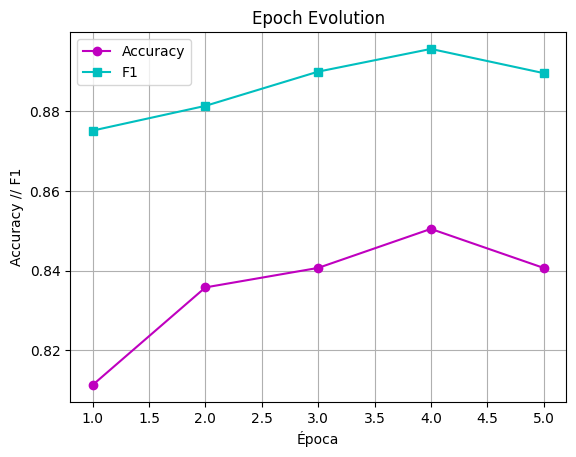

In [5]:
import matplotlib.pyplot as plt

accuracies = [m["accuracy"] for m in all_metrics]
f1s = [z["f1"] for z in all_metrics]
plt.plot(range(1, num_epochs+1), accuracies, marker='o', c="m")
plt.plot(range(1, num_epochs+1), f1s, marker='s', c="c")
plt.title("Epoch Evolution")
plt.xlabel("Época")
plt.ylabel("Accuracy // F1")
plt.legend(["Accuracy", "F1"])
plt.grid()
plt.show()